# Helper Function

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.title("Natural Electricity Demand from 1 Mar 2015 to 13 Dec 2019", fontsize=16)
  plt.xlabel("Time")
  plt.ylabel("Nat Demand")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

def prepare_data_with_window(data, n_steps_in, n_steps_out):
  X, y = [], []
  for i in range(len(data)):
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      if out_end_ix > len(data):
          break
      seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, 0]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

# Importing Data

In [3]:
import pandas as pd
train = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/RNN/Data\/train.csv",
                 parse_dates=["datetime"],
                 index_col=["datetime"])
train.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-03-01 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-03-01 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-03-01 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-03-01 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-03-01 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
actual_predict = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/RNN/Data\/Predict_Jan.csv",
                 parse_dates=["datetime"],
                 index_col=["datetime"])
actual_predict.head()

,nat_demand
datetime,
2020-01-01 00:00:00,1032.2630
2020-01-01 01:00:00,1017.5806
2020-01-01 02:00:00,1000.2797
2020-01-01 03:00:00,987.2383
2020-01-01 04:00:00,970.3667


In [5]:
test = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/RNN/Data\/Test_Jan.csv",
                   parse_dates=["datetime"],
                   index_col=["datetime"])

test = pd.merge(test, actual_predict, on='datetime', how='inner')
test['nat_demand'] = test['nat_demand_y']
test = test.drop(['nat_demand_x', 'nat_demand_y'], axis=1)
test = test[train.columns]
test.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1032.2630,25.809259,0.018042,0.032806,14.849625,23.301447,0.017035,0.021866,4.559083,22.598322,0.016195,0.068054,3.737708,1,1,0
2020-01-01 01:00:00,1017.5806,25.650842,0.018065,0.053177,15.933757,23.041467,0.016936,0.023796,4.846412,22.471155,0.016104,0.080109,3.591759,1,1,0
2020-01-01 02:00:00,1000.2797,25.501489,0.018119,0.069000,16.806818,22.806177,0.016822,0.024910,5.204608,22.368677,0.016013,0.094757,3.704177,1,1,0
2020-01-01 03:00:00,987.2383,25.430994,0.018142,0.080017,17.460632,22.657556,0.016746,0.025208,5.628076,22.282556,0.015937,0.107086,3.936592,1,1,0
2020-01-01 04:00:00,970.3667,25.360132,0.018204,0.084137,16.632112,22.539819,0.016647,0.022789,5.729821,22.203882,0.015862,0.113800,4.088643,1,1,0


# Visualization

In [6]:
import csv
from datetime import datetime

timesteps_train = []
nat_demand_train = []
with open(r"/content/drive/MyDrive/Colab Notebooks/RNN/Data\/train.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader)
  for line in csv_reader:
    timesteps_train.append(datetime.strptime(line[0], "%d-%m-%Y %H:%M"))
    nat_demand_train.append(float(line[1]))

# View first 10 of each
timesteps_train[:10], nat_demand_train[:10]

([datetime.datetime(2015, 1, 3, 1, 0),
  datetime.datetime(2015, 1, 3, 2, 0),
  datetime.datetime(2015, 1, 3, 3, 0),
  datetime.datetime(2015, 1, 3, 4, 0),
  datetime.datetime(2015, 1, 3, 5, 0),
  datetime.datetime(2015, 1, 3, 6, 0),
  datetime.datetime(2015, 1, 3, 7, 0),
  datetime.datetime(2015, 1, 3, 8, 0),
  datetime.datetime(2015, 1, 3, 9, 0),
  datetime.datetime(2015, 1, 3, 10, 0)],
 [970.345,
  912.1755,
  900.2688,
  889.9538,
  893.6865,
  879.2323,
  932.4876,
  1048.972,
  1167.9074,
  1257.5069])

In [7]:
timesteps_test = []
nat_demand_test = []
with open(r"/content/drive/MyDrive/Colab Notebooks/RNN/Data\/Test_Jan.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader)
  for line in csv_reader:
    timesteps_test.append(datetime.strptime(line[0], "%d-%m-%Y %H:%M"))
    nat_demand_test.append(float(line[1]))

# View first 10 of each
timesteps_test[:10], nat_demand_test[:10]

([datetime.datetime(2020, 1, 1, 0, 0),
  datetime.datetime(2020, 1, 1, 1, 0),
  datetime.datetime(2020, 1, 1, 2, 0),
  datetime.datetime(2020, 1, 1, 3, 0),
  datetime.datetime(2020, 1, 1, 4, 0),
  datetime.datetime(2020, 1, 1, 5, 0),
  datetime.datetime(2020, 1, 1, 6, 0),
  datetime.datetime(2020, 1, 1, 7, 0),
  datetime.datetime(2020, 1, 1, 8, 0),
  datetime.datetime(2020, 1, 1, 9, 0)],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

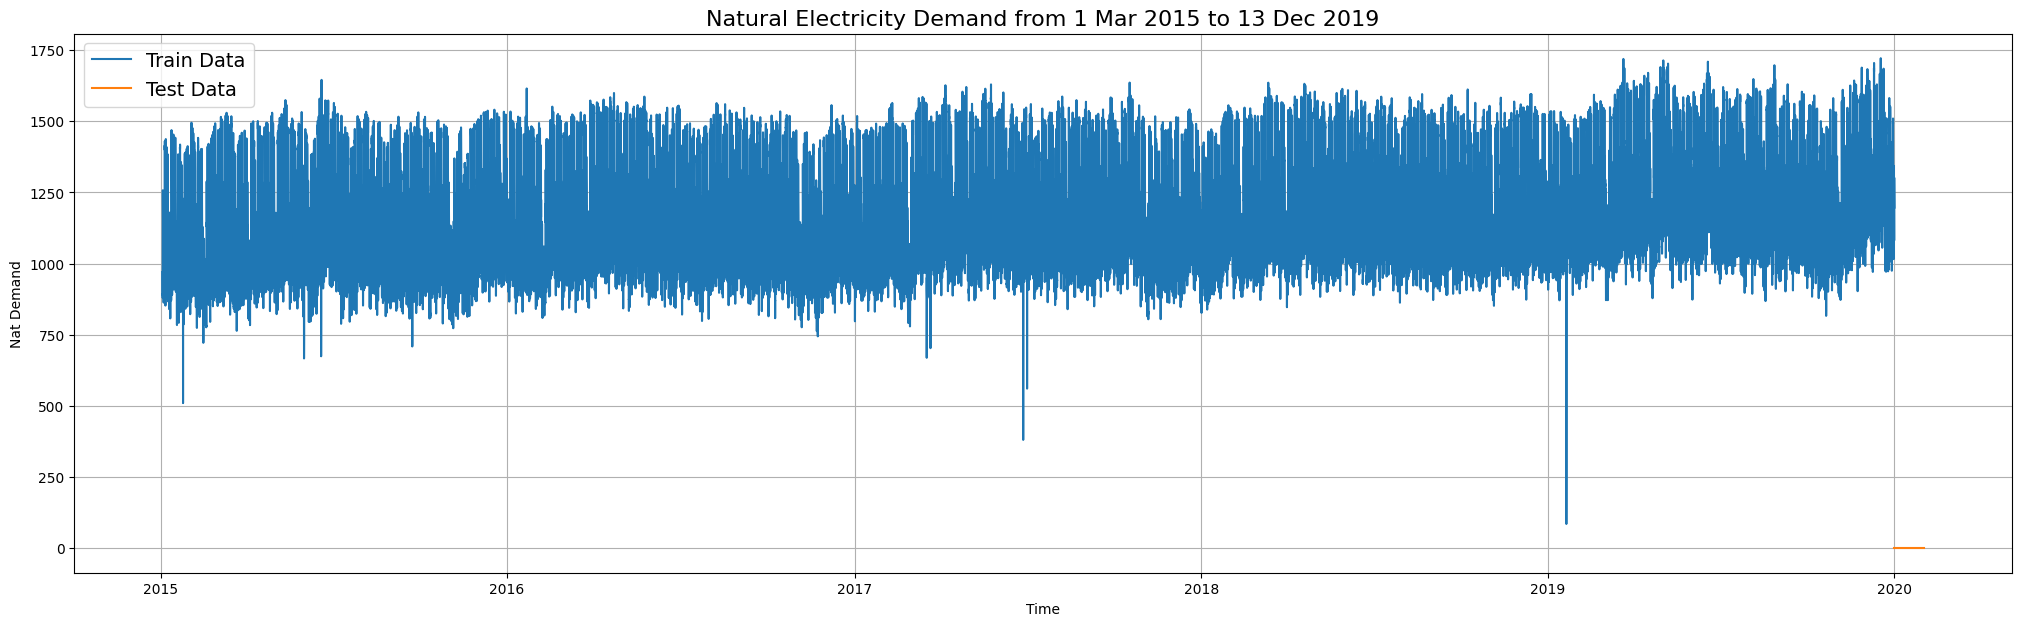

In [9]:
plt.figure(figsize=(25, 7))
plot_time_series(timesteps=timesteps_train, values=nat_demand_train, format='-', label="Train Data")
plot_time_series(timesteps=timesteps_test, values=nat_demand_test, format='-', label="Test Data")

# Preprocessing

**Check Missing Value**

In [10]:
train.isna().sum()

nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

In [11]:
test.isna().sum()

nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

**Remove Unwanted Column**

In [12]:
train.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [13]:
features = ['T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav', 'holiday', 'school']
target = 'nat_demand'

In [14]:
col=['Holiday_ID','holiday', 'school']
train= train.drop(columns=col)
test= test.drop(columns=col)

**lag features**

In [15]:
for i in range(1, 8):
    train[f'{target}_lag_{i}'] = train[target].shift(i)
    test[f'{target}_lag_{i}'] = test[target].shift(i)

test.dropna(inplace=True)
train.dropna(inplace=True)

In [16]:
test.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,nat_demand_lag_1,nat_demand_lag_2,nat_demand_lag_3,nat_demand_lag_4,nat_demand_lag_5,nat_demand_lag_6,nat_demand_lag_7
datetime,,,,,,,,,,,,,,,,,,,,
2020-01-01 07:00:00,924.4692,26.073602,0.018570,0.079956,16.127368,23.831415,0.016922,0.015656,8.454858,22.417352,0.015922,0.095795,4.056486,922.3729,957.6767,970.3667,987.2383,1000.2797,1017.5806,1032.2630
2020-01-01 08:00:00,954.3947,26.938074,0.018493,0.102783,20.179076,25.461511,0.017341,0.016876,9.816476,23.172449,0.015937,0.078796,4.277817,924.4692,922.3729,957.6767,970.3667,987.2383,1000.2797,1017.5806
2020-01-01 09:00:00,986.0648,27.672021,0.018401,0.105927,22.823427,26.953271,0.017470,0.014187,11.696469,24.250146,0.015830,0.050323,4.394933,954.3947,924.4692,922.3729,957.6767,970.3667,987.2383,1000.2797
2020-01-01 10:00:00,989.1948,28.329095,0.018401,0.113586,24.016658,28.063470,0.017562,0.012226,12.490295,25.438470,0.015654,0.030548,4.558984,986.0648,954.3947,924.4692,922.3729,957.6767,970.3667,987.2383
2020-01-01 11:00:00,1005.6986,28.846826,0.018485,0.127563,24.473000,28.706201,0.017584,0.013699,12.599918,26.393701,0.015376,0.019577,4.569095,989.1948,986.0648,954.3947,924.4692,922.3729,957.6767,970.3667


**Scale the Data**

In [17]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = [col for col in train.columns if col != 'nat_demand']

scaler = MinMaxScaler()
scaler.fit(train[columns_to_scale])

train_scaled = train.copy()
train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale])

test_scaled = test.copy()
test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])

In [18]:
# Define window size and forecast horizon
n_steps_in = 7
n_steps_out = 1

# Prepare data for LSTM
X_train, y_train = prepare_data_with_window(train_scaled.values, n_steps_in, n_steps_out)
X_test, y_test = prepare_data_with_window(test_scaled.values, n_steps_in, n_steps_out)

In [19]:
# Reshape input for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Model

In [20]:
epoch = 20
lr = 0.0001
batch_size = 32
layer_unit = 50

**Reproducibility Settings**

In [21]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
np.random.seed(42)
tf.random.set_seed(42)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
tf.compat.v1.set_random_seed(42)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

**Create Model**

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers import RMSprop, SGD, Adamax, Adagrad, Adam

tf.keras.utils.set_random_seed(42)

# Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps_in, X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_steps_out))
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             21760     
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 92033 (359.50 KB)
Trainable params: 92033 (359.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Train Model**

In [24]:
# Train the model
model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

Epoch 1/20
1368/1368 [==============================] - 52s 35ms/step - loss: 116052.9844
Epoch 2/20
1368/1368 [==============================] - 47s 34ms/step - loss: 1510.4337
Epoch 3/20
1368/1368 [==============================] - 47s 34ms/step - loss: 1380.7936
Epoch 4/20
1368/1368 [==============================] - 45s 33ms/step - loss: 1286.5336
Epoch 5/20
1368/1368 [==============================] - 45s 33ms/step - loss: 1222.2787
Epoch 6/20
1368/1368 [==============================] - 45s 33ms/step - loss: 1118.8807
Epoch 7/20
1368/1368 [==============================] - 45s 33ms/step - loss: 1082.4889
Epoch 8/20
1368/1368 [==============================] - 45s 33ms/step - loss: 1080.3625
Epoch 9/20
1368/1368 [==============================] - 45s 33ms/step - loss: 1127.0486
Epoch 10/20
1368/1368 [==============================] - 45s 33ms/step - loss: 1022.9882
Epoch 11/20
1368/1368 [==============================] - 45s 33ms/step - loss: 1192.8539
Epoch 12/20
1368/1368 [=====

**Evaluate**

In [27]:
results = evaluate_preds(y_true=y_test.flatten(),
                         y_pred=y_pred.flatten())

results

{'mae': 26.594273,
 'mse': 1344.3774,
 'rmse': 36.665752,
 'mape': 2.0683272,
 'mase': 0.5700094}

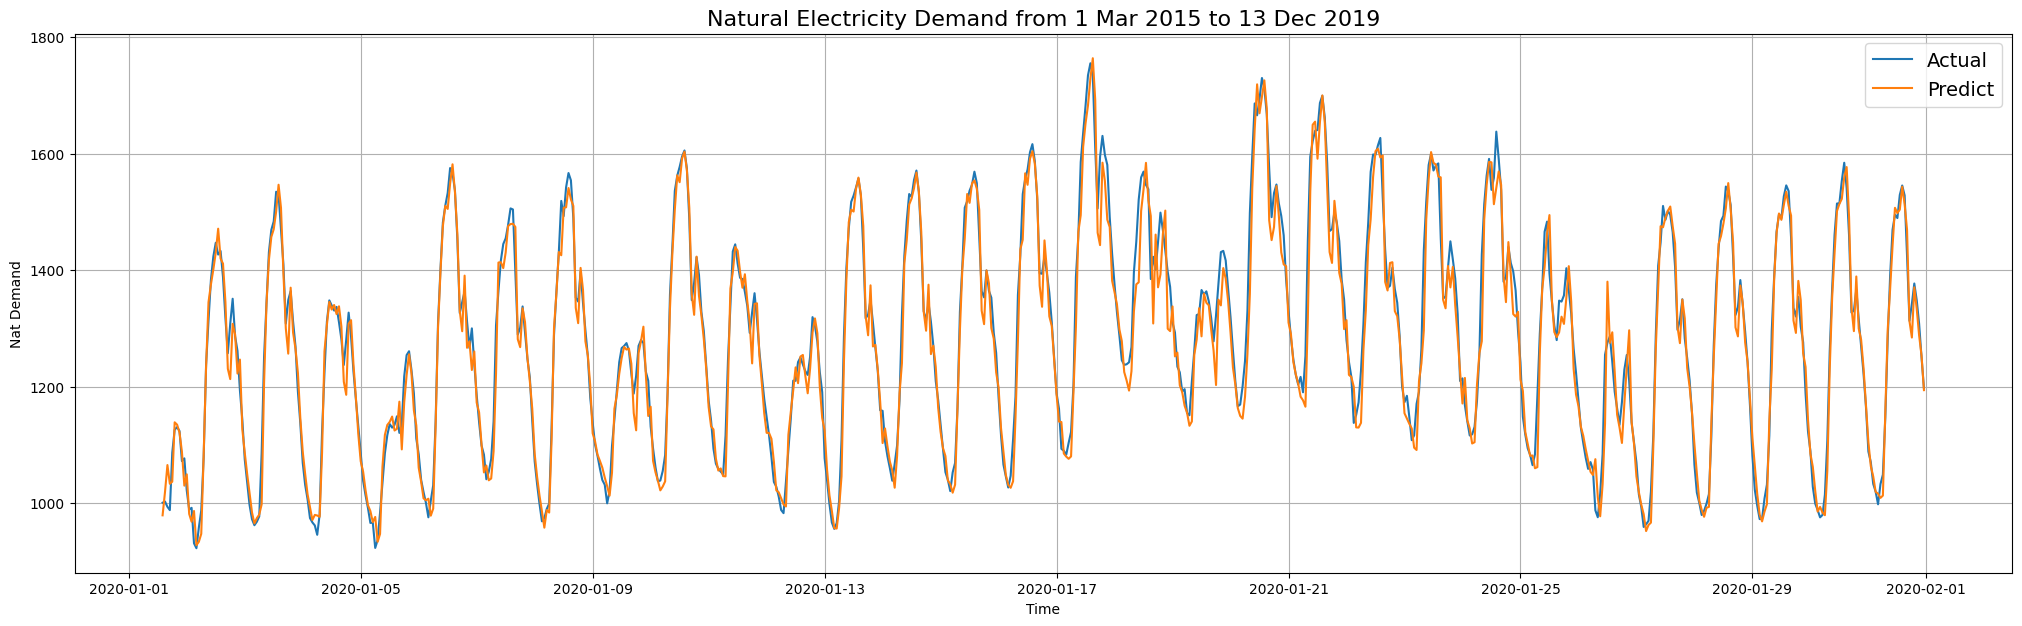

In [28]:
plt.figure(figsize=(25, 7))
plot_time_series(timesteps=timesteps_test[-len(X_test):], values=y_test.flatten(), format='-', label="Actual")
plot_time_series(timesteps=timesteps_test[-len(X_test):], values=y_pred.flatten(), format='-', label="Predict")